In [ ]:
########################################################################################################################
# Filename: tfidf_Dimension_Reduction.ipynb
#
# Purpose: Generate both liner and nonlinear, low dimensional representations of sparse tf-idf vectors.

# Author(s): Bobby (Robert) Lumpkin, Archit Datar (PCA)
#
# Library Dependencies: numpy, pandas, scikit-learn
########################################################################################################################

# Dimension Reduction for Text Classification 

In [43]:
from sklearn.decomposition import PCA, IncrementalPCA
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.models import Model

## Linear Representations (Principal Components Analysis)

There are multiple approaches we could take towards determining the number of appropriate principal components to retain. One approach requires a certain proportion of explained variance. Another, sets a maximum acceptable dimension for dimension reduction purposes. 
Another yet, involves treating the number of PCs as a hyperparameter and choosing a value via grid search. Since we plan to train multiple different models, we'll only try use the first two approaches throughout this project, for the sake of brevity.

In [2]:
## Load the data
npzfile = np.load("Data/tfidf_trainTest_data.npz")
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']
Y_tfidfTrain = npzfile['Y_tfidfTrain']
Y_tfidfTest = npzfile['Y_tfidfTest']
feature_names = npzfile['feature_names']

In [3]:
## (CAUTION: NO NEED TO RUN. LOAD DATA IN NEXT CELL) -- Fit a PCA object to the training data and save the array of coordinates 
##                                                      for the full set of PCs
#pca = PCA(n_components = min(X_tfidfTrain.shape[0], X_tfidfTrain.shape[1]))
#X_pcaTrain = pca.fit_transform(X_tfidfTrain)
#outfile = "Data/PC_scores_full"
#np.savez_compressed(outfile, X_pcaTrain = X_pcaTrain)

In [78]:
## If needed, load pre-fit and transformed PCA object and scores
pca = load("Models/PCA_fit.joblib")
npzfile = np.load("Data/PC_scores_full.npz")
X_pcaTrain = npzfile['X_pcaTrain']

Target cumulative variance:  0.60
Number of principal components: 1084
Maximum number of permissible PCs: 50
Cumulative variance using 50 PCs:  0.19


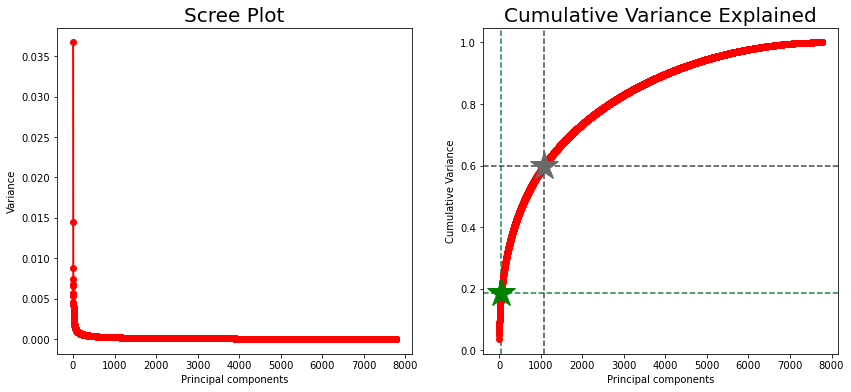

In [79]:
## Generate scree & cumulative variance plots and save the fit PCA object as a .joblib doc
PC_id = np.arange(pca.n_components_) + 1

# Scree plot .
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121)
ax1.plot(PC_id, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_xlabel("Principal components")
ax1.set_ylabel("Variance")
ax1.set_title("Scree Plot", size = 20)

# Cumulative variance plot
cum_var = np.cumsum(pca.explained_variance_ratio_) #cumulative variance.
target_cum_var = 0.6    # Target cumulative variance.
PCs_retained = np.where(cum_var>target_cum_var)[0][0] + 1    # Number of principal components retained to explain target
max_numPCs = 50    # Maximum number of PCs to be considered

ax2 = fig.add_subplot(122)
ax2.plot(PC_id, cum_var, 'ro-', linewidth=2)
ax2.set_xlabel("Principal components")
ax2.set_ylabel("Cumulative Variance")
ax2.set_xlim()
ax2.set_ylim()
ax2.hlines(target_cum_var, ax2.get_xlim()[0], ax2.get_xlim()[1], linestyles = "--", colors = plt.cm.Greys(200))
ax2.hlines(cum_var[max_numPCs - 1], ax2.get_xlim()[0], ax2.get_xlim()[1], linestyles = "--", colors = plt.cm.Greens(200))
ax2.vlines(PCs_retained, ax2.get_ylim()[0], ax2.get_ylim()[1], linestyles = "--", colors = plt.cm.Greys(200))
ax2.vlines(max_numPCs, ax2.get_ylim()[0], ax2.get_ylim()[1], linestyles = "--", colors = plt.cm.Greens(200))
ax2.plot(PCs_retained, target_cum_var, color = 'dimgrey', marker = '*', markersize = 30)
ax2.plot(max_numPCs, cum_var[max_numPCs - 1], 'g*', markersize = 30)
ax2.set_title("Cumulative Variance Explained", size = 20)

# (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Save the PCA fit
#dump(pca, 'Models/PCA_fit.joblib') 

print(f"Target cumulative variance: {target_cum_var: .2f}")
print(f"Number of principal components: {PCs_retained}")
print(f"Maximum number of permissible PCs: {max_numPCs}")
print(f"Cumulative variance using {max_numPCs} PCs: {cum_var[max_numPCs - 1]: .2f}")

In [74]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Save the PC scores for both approaches
PC_scores_maxNum = X_pcaTrain[:, 0 : max_numPCs]
PC_scores_cumVar = X_pcaTrain[:, 0 : PCs_retained]

outfile = "Data/PC_scores_reduced.npz"
#np.savez_compressed(outfile, PC_scores_maxNum = PC_scores_maxNum, 
#                             PC_scores_cumVar = PC_scores_cumVar)

## Nonlinear Representations (ANN Autoencoder)